<h2>CS 4780/5780 Final Project: </h2>
<h3>Election Result Prediction for US Counties</h3>

Names and NetIDs for your group members: Casey Justus (cnj6), Iain Pile (imp25), Bryan Tantisujjatham (bbt27)

<h3>Introduction:</h3>

<p> The final project is about conducting a real-world machine learning project on your own, with everything that is involved. You now start from scratch. The programming project provide templates for how to do this, and the most recent video lectures summarize some of the tricks you will need (e.g. feature normalization, feature construction). So, this final project brings realism to how you will use machine learning in the real world.  </p>

The task you will work on is forecasting election results. Economic and sociological factors have been widely used when making predictions on the voting results of US elections. Economic and sociological factors vary a lot among counties in the United States. In addition, as you may observe from the election map of recent elections, neighbor counties show similar patterns in terms of the voting results. In this project you will bring the power of machine learning to make predictions for the county-level election results using Economic and sociological factors and the geographic structure of US counties. </p>
<p>

<h3>Your Task:</h3>
Plase read the project description PDF file carefully and make sure you write your code and answers to all the questions in this Jupyter Notebook. Your answers to the questions are a large portion of your grade for this final project. Please import the packages in this notebook and cite any references you used as mentioned in the project description. You need to print this entire Jupyter Notebook as a PDF file and submit to Gradescope and also submit the ipynb runnable version to Canvas for us to run.

<h3>Due Date:</h3>
The final project dataset and template jupyter notebook will be due on <strong>December 15th</strong> . Note that <strong>no late submissions will be accepted</strong>  and you cannot use any of your unused slip days before.
</p>

![image.png; width="100";](attachment:image.png)

<h2>Part 1: Basics</h2><p>

<h3>1.1 Import:</h3><p>
Please import necessary packages to use. Note that learning and using packages are recommended but not required for this project. Some official tutorial for suggested packacges includes:
    
https://scikit-learn.org/stable/tutorial/basic/tutorial.html
    
https://pytorch.org/tutorials/
    
https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
<p>

In [ ]:
#import libraries
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import classification_report

<h3>1.2 Weighted Accuracy:</h3><p>
Since our dataset labels are heavily biased, you need to use the following function to compute weighted accuracy throughout your training and validation process and we use this for testing on Kaggle.
<p>

In [ ]:
def weighted_accuracy(pred, true):
    assert(len(pred) == len(true))
    num_labels = len(true)
    num_pos = sum(true)
    num_neg = num_labels - num_pos
    frac_pos = num_pos/num_labels
    weight_pos = 1/frac_pos
    weight_neg = 1/(1-frac_pos)
    num_pos_correct = 0
    num_neg_correct = 0
    for pred_i, true_i in zip(pred, true):
        num_pos_correct += (pred_i == true_i and true_i == 1)
        num_neg_correct += (pred_i == true_i and true_i == 0)
    weighted_accuracy = ((weight_pos * num_pos_correct) 
                         + (weight_neg * num_neg_correct))/((weight_pos * num_pos) + (weight_neg * num_neg))
    return weighted_accuracy

<h2>Part 2: Baseline Solution</h2><p>
Note that your code should be commented well and in part 2.4 you can refer to your comments. (e.g. # Here is SVM, 
# Here is validation for SVM, etc). Also, we recommend that you do not to use 2012 dataset and the graph dataset to reach the baseline accuracy for 68% in this part, a basic solution with only 2016 dataset and reasonable model selection will be enough, it will be great if you explore thee graph and possibly 2012 dataset in Part 3.

In [ ]:
#import content from google drive
from google.colab import drive
drive.mount('/content/drive')

<h3>2.1 Preprocessing and Feature Extraction:</h3><p>
Given the training dataset and graph information, you need to correctly preprocess the dataset (e.g. feature normalization). For baseline solution in this part, you might not need to introduce extra features to reach the baseline test accuracy.
<p>

In [ ]:
# Loading the training data into df_train, a pandas dataframe
train_path = os.path.join(os.getcwd(), "drive", "MyDrive", "CS4780 Final Project", "train", "train_2016.csv")
df_train = pd.read_csv(train_path, sep=',',header=None, encoding='unicode_escape')

# Loading the testing data into df_test, a pandas dataframe
test_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS4780 Final Project", "test", "test_2016_no_label.csv")
df_test = pd.read_csv(test_path, sep=',',header=None, encoding='unicode_escape')

# Converting dataframe into numpy array
train = df_train.to_numpy()
test = df_test.to_numpy()

In [ ]:
print(train)
print(test)

[['FIPS' 'County' 'DEM' ... 'DeathRate' 'BachelorRate' 'UnemploymentRate']
 ['18019' 'Clark County, IN' '18791' ... '11.0' '20.9' '4.2']
 ['6035' 'Lassen County, CA' '2026' ... '6.3' '12.0' '6.9']
 ...
 ['27065' 'Kanabec County, MN' '2327' ... '10.4' '14.6' '6.5']
 ['17139' 'Moultrie County, IL' '1476' ... '13.0' '19.5' '4.6']
 ['20185' 'Stafford County, KS' '303' ... '12.1' '23.9' '3.7']]
[['FIPS' 'County' 'MedianIncome' ... 'DeathRate' 'BachelorRate'
  'UnemploymentRate']
 ['17059' 'Gallatin County, IL' '39,634' ... '12.5' '9.9' '7.6']
 ['6103' 'Tehama County, CA' '40,585' ... '10.4' '15.5' '7.1']
 ...
 ['42107' 'Schuylkill County, PA' '50,299' ... '13.4' '16.2' '6.2']
 ['48293' 'Limestone County, TX' '39,382' ... '11.3' '14' '5.6']
 ['37087' 'Haywood County, NC' '45,290' ... '12.6' '25' '4.5']]


In [ ]:
def preprocess(xTr, xTe):
  """
  Normalize the features of the training set to be zero-mean and have a standard
  deviation of 1, then perform the same operations on the testing set.

  Input:
    xTr: (nxd) training data
    xTe: (mxd) testing data
  Output: 
    xTr: (nxd) normalized training data
    xTe: (mxd) normalized testing data
  """
  s = np.std(xTr, axis=0)
  m = np.mean(xTr, axis=0)

  xTr = (xTr - m) / s
  xTe = (xTe - m) / s

  return xTr, xTe

In [ ]:
# Removing comma from median income
for i in range(1, len(train)):
  train[i][4] = train[i][4].replace(",", "")

for i in range(1, len(test)):
  test[i][2] = test[i][2].replace(",", "")

In [ ]:
#convert data to correct types
xTr_up = train[1:, 4:].astype(np.float)
dem_votes = train[1:, 2].astype(np.int)
gop_votes = train[1:, 3].astype(np.int)
xTe_up = test[1:, 2:].astype(np.float)
yTr = np.sign(dem_votes - gop_votes)
#set gop to 0
for i in range(len(yTr)):
  if yTr[i] == -1:
    yTr[i] = 0
assert(len(xTr) == len(yTr))

#preprocess data
xTr, xTe = preprocess(xTr_up, xTe_up)
test_FIPS = test[1:, 0]

<h3>2.2 Use At Least Two Training Algorithms from class:</h3><p>
You need to use at least two training algorithms from class. You can use your code from previous projects or any packages you imported in part 1.1.

<h4> Soft-Margin SVM Classifier

In [ ]:
#scoring
def customScore(estimator, X, y):
  return weighted_accuracy(estimator.predict(X), y)

#SVM model
def predSVM(X_train, y_train):
  clf = GridSearchCV(estimator=SVC(),
          param_grid= {'C': [.1, 1, 10, 100, 1000], 
                      'gamma': [10, 1, 0.5, 0.1, 0.01], 
                      'kernel': ['linear', 'rbf']},
                      scoring=customScore)
  print("Fitting")
  clf.fit(X_train, y_train)
  print("Optimized parameters (from grid search):", clf.best_params_)
  print("Weighted validation score:", clf.best_score_)
  return clf

<h4> Neural Network Classifier

In [ ]:
#Neural Network model
def predNN(X_train, y_train):
  clf = GridSearchCV(estimator=MLPClassifier(),
          param_grid={'hidden_layer_sizes': [50, 100, 200],
                      'activation': ['relu', 'tanh', 'sigmoid'],
                      'solver': ['sgd','lbfgs'],
                      'max_iter': [1000, 2000]},
                      scoring=customScore)
  print("Fitting")
  clf.fit(X_train, y_train)
  print("Optimized parameters:", clf.best_params_)
  print("Weighted validation score:", clf.best_score_)
  return clf

<h3>2.3 Training, Validation and Model Selection:</h3><p>
You need to split your data to a training set and validation set or performing a cross-validation for model selection.

In [ ]:
# cross validation and hyper-parameter tuning implemented with GridSearch
classifier = predSVM(xTr, yTr)
preds = classifier.predict(xTe)

In [ ]:
assert(len(test_FIPS) == len(preds))
submission = np.column_stack((test_FIPS, preds))
pd.DataFrame(data=submission, columns=["FIPS", "Result"]).to_csv("svmtest.csv", index=False)

In [ ]:
classifier = predNN(xTr, yTr)
predsNN = classifier.predict(xTe)

In [ ]:
assert(len(test_FIPS) == len(preds))
submission = np.column_stack((test_FIPS, preds))
pd.DataFrame(data=submission, columns=["FIPS", "Result"]).to_csv("nntest.csv", index=False)

<h3>2.4 Explanation in Words:</h3><p>
    You need to answer the following questions in the markdown cell after this cell:

2.4.1 How did you preprocess the dataset and features?

We standardized the training set so that all features had a mean of zero and a standard deviation of 1 to ensure data was all scaled properly. A quick scan of the dataset found that there were no missing features (at least in the 2016 dataset), so we didn't see the need to impute any features.

2.4.2 Which two learning methods from class did you choose and why did you made the choices?

- The first learning method we used was a soft-margin SVM with an rbf kernel. We used Scikit-learn's svm.SVC class, and built both the training and validation of the model into one function `predSVM`, which does k-fold cross-validation and gridsearch, before returning a trained SVM classifier that can be used on the testing set. We figured this was an easily understood model that could capture potential complexity via kernels, and was well-suited to a binary classification problem like this one.

- After that, we tried a neural network (scikit-learn's multi-layer perceptron) with a (1) ReLU activation function, (2) a single hidden layer size of (3) 50 nodes, and using the (4) lbfgs optimizer. We figured that a neural network would be good at combining these features in ways that a SVM implementation might not be able to capture, and given sklearn's implementation uses perceptron, it seemed well-suited to the task of binary classification. We implemented this model in a similar way to our SVM in the `predNN` function, which performs k-fold cross validation and gridsearch before returning a neural network classifier.

2.4.3 How did you do the model selection?

- For our SVM model, our model selection was built into our training function. We called `GridSearchCV`, which does a grid search across the necessary parameters (in this case, $C$ and the rbf kernel's gamma parameter), to find the combination of parameters that maximizes the weighted accuracy (implemented in our customScorer function), and also performs 5-fold cross validation to find the best subset of the dataset to train on. In our case, it found the best $C$ to be 1000, and the best gamma to be 0.01. 
  - We felt that 5 folds were reasonable; this meant that our model would be trained on 80% of the data for each iteration, and validated on 20% of the testing data. We wanted to ensure sufficient examples in our training set, and .80 * (1555) = 1244 examples seemed sufficient for each iteration.
  - We tried a range of C values (small, medium, and large). This varies the penalty for misclassified points and therefore the margin. The high $C$ value indicates that the best results came when there was a small margin, and could be a sign that the model is overfitting the data.
  - We chose the range of gamma values based on the radial basis function. The low values indicates a larger similarity radius and in turn more points are grouped together. The larger values tend to overfit, as the points have to be very close to be in the same class. The model was optimized with a smaller value of gamma, which means it is less likely to be overfitting in that regard.
- Our neural network model used similar methods to our SVM one, with sklearn's `GridSearchCV` to perform 5-fold cross validation and gridsearch over parameters. For this one, we trained over sklearn's different activation functions, solvers for backpropagation, hidden layer size, and the number of iterations. We figured this covered a lot of variety in the NN. 
  - We included several activation functions in the gridsearch, although we didn't want to use the identity, as that would limit the capabilities of any tests using it to only linear decisions, and decided the other three activation functions were sufficient. 
- Our goal was to reach the baseline accuracy while minimizing runtime. We justified the choice of lbfgs over Adam and sgd because for small datasets and lower dimensional models it is just as good, if not stabler and faster. The downside is its higher memory requirements, but since our model was not very complex, lbgfs was appropriate to use. It also made sense to use a ReLU activation function, because it is not subject to the problem of vanishing gradients like other nonlinear activation functions (e.g. tanh, sigmoid), in that its gradients do not saturate. Finally, a single layer of 50 nodes makes sense if we want to minimize model complexity (and thus training time) while still reaching the baseline accuracy; it seemed sufficient to capture the problem, while not being overly complex. Since this value was chosen by GridSearch, it seemed to suggest that using more nodes (100 or 200) led to overfitting for our one-layer model.

2.4.4 Does the test performance reach a given baseline 68% performance? (Please include a screenshot of Kaggle Submission)

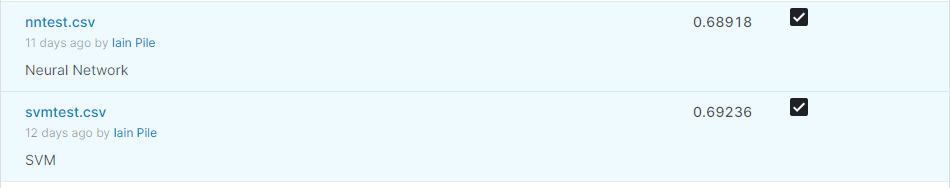

In [ ]:
from IPython.display import Image

Image(filename="drive/My Drive/CS4780 Final Project/simplebaseline.png")

<h2>Part 3: Creative Solution</h2><p>

<h3>3.1 Open-ended Code:</h3><p>
You may follow the steps in part 2 again but making innovative changes like creating new features, using new training algorithms, etc. Make sure you explain everything clearly in part 3.2. Note that reaching the 75% creative baseline is only a small portion of this part. Any creative ideas will receive most points as long as they are reasonable and clearly explained.

<h4> Processing

In [ ]:
# Loading the training data into df_train, a pandas dataframe
train_path2012 = os.path.join(os.getcwd(), "drive", "MyDrive", "CS4780 Final Project", "train", "train_2012.csv")
df_train2012 = pd.read_csv(train_path2012, sep=',',header=None, encoding='unicode_escape')

# Loading the testing data into df_test, a pandas dataframe
test_path2012 = os.path.join(os.getcwd(), "drive", "My Drive", "CS4780 Final Project", "test", "test_2012_no_label.csv")
df_test2012 = pd.read_csv(test_path2012, sep=',',header=None, encoding='unicode_escape')

# Loading the graph data into df_graph, a pandas dataframe
test_graph = os.path.join(os.getcwd(), "drive", "My Drive", "CS4780 Final Project", "train", "graph.csv")
df_graph = pd.read_csv(test_graph, sep=',',header=None, encoding='unicode_escape')

# Converting dataframe into numpy array
train2012 = df_train2012.to_numpy()
test2012 = df_test2012.to_numpy()
graph = df_graph.to_numpy()

# Removing comma from median income
for i in range(1, len(train2012)):
  train2012[i][4] = train2012[i][4].replace(",", "")

for i in range(1, len(test2012)):
  test2012[i][2] = test2012[i][2].replace(",", "")

#format training and testing data
xTr12 = train2012[1:, 4:].astype(np.float)
xTe12 = test2012[1:, 2:].astype(np.float)
xTr12, xTe12 = preprocess(xTr12, xTe12)

In [ ]:
# change in birth/death rate between 2012 and 2016 new feature
change_birth=xTr12[:,3]-xTr[:,3]
change_birth.shape=(1555,1)

change_death=xTr12[:,4]-xTr[:,4]
change_death.shape=(1555,1)

change_birth_test=xTe12[:,3]-xTe[:,3]
change_birth_test.shape=(len(change_birth_test),1)
change_death_test=xTe12[:,4]-xTe[:,4]
change_death_test.shape=(len(change_death_test),1)

<h5> Neighbor Relationships

In [ ]:
# creating a mapping of FIPS scores to label for use in determining adjacent votes
FIPS_vote_map = {}
data = train[1:]
for i in range(len(data)):
  FIPS_vote_map[data[i][0]] = yTr[i]
FIPS_set = set(FIPS_vote_map.keys())

In [ ]:
# create a mapping of FIPS score to most common label among neighbors
neighbors = {}
for src, dest in graph:
  if src != dest:
    if dest in FIPS_set:
      if src in neighbors.keys():
        neighbors[src].append(FIPS_vote_map[dest])
      else:
        neighbors[src] = [FIPS_vote_map[dest]]

neighbor_maps = {}
for f, n in neighbors.items():
  neighbor_maps[f] = np.bincount(np.array(n, dtype=int)).argmax()

In [ ]:
# if a county has no neighbor information, impute the missing value
trNeighbors = []
trImpute = []
for ex in train[1:]:
  if ex[0] in neighbor_maps.keys():
    trNeighbors.append(neighbor_maps[ex[0]])
    trImpute.append(0)
  else:
    trNeighbors.append(0)
    trImpute.append(1)

teNeighbors = []
teImpute = []
for ex in test[1:]:
    if ex[0] in neighbor_maps.keys():
      teNeighbors.append(neighbor_maps[ex[0]])
      teImpute.append(0)
    else:
      teNeighbors.append(0)
      teImpute.append(1)

# get arrays indicating num neighbors, or if that information is missing
nTr = np.array(trNeighbors, dtype=np.float)
iTr = np.array(trImpute, dtype=np.float)
nTe = np.array(teNeighbors, dtype=np.float)
iTe = np.array(teImpute, dtype=np.float)

In [ ]:
# reshape arrays
nTr = np.reshape(nTr, (len(nTr), 1))
iTr = np.reshape(iTr, (len(iTr), 1))
nTe = np.reshape(nTe, (len(nTe), 1))
iTe = np.reshape(nTr, (len(iTe), 1))

Birth/Death Rates

In [ ]:
#add change in birth/death rate to testing and training sets
data=np.append(train[1:,4:],change_birth,axis=1)
data=np.append(train[1:,4:],change_death,axis=1)

data_Te=np.append(test[1:,2:],change_birth_test,axis=1)
data_Te=np.append(test[1:,2:], change_death_test,axis=1)

xTr = np.hstack((xTr, nTr, iTr)).astype(np.float)
xTe = np.hstack((xTe, nTe, iTe)).astype(np.float)

# preprocess new dataset
xTr, xTe = preprocess(data.astype(np.float), data_Te.astype(np.float))


<h4> Model

In [ ]:
# Neural Network to generate predictions.
def predNN_2(X_train, y_train):
  clf = GridSearchCV(estimator=MLPClassifier(),
          param_grid={'hidden_layer_sizes': [50, 100, 125, 150, 200],
                      'activation': ['relu', 'tanh'],
                      'solver': ['sgd','lbfgs', 'adam'],
                      'max_iter': [1000, 2000]},
                      scoring=customScore)
  print("Fitting")
  clf.fit(X_train, y_train)
  print("Optimized parameters:", clf.best_params_)
  print("Weighted validation score:", clf.best_score_)
  return clf

In [ ]:
#Neural Network to generate predictions
def predNN_2(X_train, y_train):
  clf = GridSearchCV(estimator=MLPClassifier(),
          param_grid={'hidden_layer_sizes': [(80, 25)],
                      'activation': ['relu'],
                      'solver': ['adam', 'lbfgs'],
                      'max_iter': [2000],
                      'learning_rate': ['constant'],
                      'learning_rate_init': [.00011, .00012, .0001, .001]},
                      scoring=customScore)
  print("Fitting")
  clf.fit(X_train, y_train)
  print("Optimized parameters:", clf.best_params_)
  print("Weighted validation score:", clf.best_score_)
  return clf

<h4> Evaluation

In [ ]:
#Calling Neural Network for Predictions
classifier = predNN_2(xTr, yTr)
preds = classifier.predict(xTe)


Fitting
Optimized parameters: {'activation': 'relu', 'hidden_layer_sizes': (80, 25), 'learning_rate': 'constant', 'learning_rate_init': 0.00012, 'max_iter': 2000, 'solver': 'adam'}
Weighted validation score: 0.7397660818713451


In [ ]:
#Save Predictions
assert(len(test_FIPS) == len(preds))
submission = np.column_stack((test_FIPS, preds))
pd.DataFrame(data=submission, columns=["FIPS", "Result"]).to_csv("creativetest2.csv", index=False)


<h3>3.2 Explanation in Words:</h3><p>

# You need to answer the following questions in a markdown cell after this cell:

3.2.1 How much did you manage to improve performance on the test set compared to part 2? Did you reach the 75% accuracy for the test in Kaggle? (Please include a screenshot of Kaggle Submission)

We managed to improve the score by approximately 8-9%, surpassing the 75% accuracy baseline.

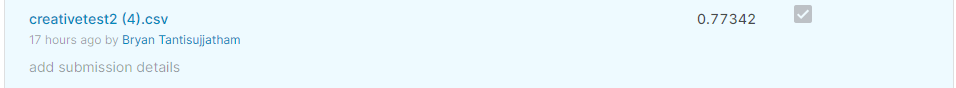

In [ ]:
Image(filename="drive/My Drive/CS4780 Final Project/creativebaseline.png")



3.2.2 Please explain in detail how you achieved this and what you did specifically and why you tried this.

**Answer:** We didn't change our model very much, and most of the parameters we considered for our gridsearch were the same as for our baseline solution. Rather, we considered a different set of features, utilizing the additional 2012 and graph datasets. Both experiments we tried improved our performanance, so we incorporated both into our training set.

- We chose to use our neural network model from the baseline solution, as it was the stronger of our two models. We implemented it in the same way, using sk-learn's `GridSearchCV` class to perform cross-validation. 

- Although birth rate and death rates were informative as features, we felt it would be useful to consider their 4 year change as well. We added two features representing the change in birth and death rate between 2012 and 2016, as some shift in that could result in a shift in demographics or attitudes in a given county (whether the number of parents increased, or more people died). This had a positive effect on our dataset.

- Intuitively, nearby counties should have similar demographics, and one would expect votes to trend in similar ways (for example, how Democratic counties tend to be heavily centered in cities, but sparse everywhere else). To account for this, we used data regarding neighboring counties to map each county to a list of its neighbors' FIPS IDs, and used those IDs to identify how most neighboring counties present in the training set voted, and added this as a feature. If none of a county's neighbors were in the training set, we assigned this feature the label 0. We added a binary impute feature that was 1 when there were no neighbors present in the training set, and 0 otherwise, to indicate that there was no data for that county. 
- We added a learning rate parameter to try for the neural network as that can have a big impact on the model. The learning rate parameter always has a small positive value, generally 0-0.1, so we chose values within that range. Changing these values changes the amount weights are updated during training. The very small value of 0.0012 indicates that smaller changes are made to the weights each update. The fact that there were learning rates smaller and larger than this is a good sign, as if the rate was too small sometimes the process can get stuck and if it is too large it can cause the model to converge too soon to an unoptimal solution (or not converge at all within the max number of iterations)
- We changed the number of hidden layers. We first ran grid search over a range of node numbers for one hidden layer (in the range of 50 to 200), which outputted 100 nodes as the optimal for one hidden layer. We then manually tweaked this number and added a second hidden layer, picking the tuple of node numbers (x, x2) where x < 100, x2 < 100, that produced the highest validation score.

<h2>Part 4: Kaggle Submission</h2><p>
You need to generate a prediction CSV using the following cell from your trained model and submit the direct output of your code to Kaggle. The CSV shall contain TWO column named exactly "FIPS" and "Result" and 1555 total rows excluding the column names, "FIPS" column shall contain FIPS of counties with same order as in the test_2016_no_label.csv while "Result" column shall contain the 0 or 1 prdicaitons for corresponding columns. A sample predication file can be downloaded from Kaggle.

In [ ]:
# TODO

# You may use pandas to generate a dataframe with FIPS and your predictions first 
# and then use to_csv to generate a CSV file.
assert(len(test_FIPS) == len(preds))
submission = np.column_stack((test_FIPS, preds))
pd.DataFrame(data=submission, columns=["FIPS", "Result"]).to_csv("creativetest.csv", index=False)

<h2>Part 5: Resources and Literature Used</h2><p>

[GridSearch Tutorial](https://scikit-learn.org/stable/modules/grid_search.html)

[Scikit-learn Tutorial](https://www.dataquest.io/blog/sci-kit-learn-tutorial) 

[Scikit-learn MLPClassifier documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

[CNNs for Visual Recognition](https://cs231n.github.io/)

[LBFGS Primer/Documentation](https://documentation.sas.com/?docsetId=casdlpg&docsetTarget=p1i430hb7ri1fnn1511qu227wtbw.htm&docsetVersion=8.3&locale=fr#:~:text=Compared%20to%20SGD%2C%20L%2DBFGS,has%20fewer%20hyperparameters%20to%20tune.)